# Neural Networks and Visualization

In [81]:
# Run this every time you open the notebook
%load_ext autoreload
%autoreload 2

from lib import lib

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/meganleszczynski/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Neural Networks for Disaster Classification

We're going to build a multi-layer perceptron (MLP) classifier with word embeddings to classify the tweets. 

### Word Embeddings 

In this section, we'll inspect pretrained word embeddings and see how we can use them in a neural network! 

Run the cell below to download the `gensim` package that makes it easy to use pretrained word embeddings. 

In [1]:
!pip install gensim

We're going to use 100-dimensional word vectors that have been trained on Twitter using the GloVe embedding algorithm (created by researchers at Stanford!). First we have to download them -- this may take several minutes to run!

In [2]:
import gensim.downloader
glove_vectors = gensim.downloader.load('glove-twitter-100')

/Users/meganleszczynski/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


By running the command `most_similar` we can find the words that have the closest word vector to the query word (i.e. nearest neighbors). 

1.) Run the two cells below to see what words are most similar to the words "disaster" and "hurricane". The numbers indicate the degree of similarity (where 1 is the highest value). "Sandy" actually occurs as a nearest neighbor of hurricane. What does this tell you about the data used to train these word embeddings? 

In [3]:
glove_vectors.most_similar('disaster')

[('tragedy', 0.6947949528694153),
 ('hurricane', 0.6831369996070862),
 ('relief', 0.674776017665863),
 ('emergency', 0.6712561249732971),
 ('disasters', 0.6636431217193604),
 ('sandy', 0.6450616121292114),
 ('victims', 0.6410350203514099),
 ('storm', 0.6376098990440369),
 ('recovery', 0.632839560508728),
 ('devastating', 0.6277540326118469)]

In [4]:
glove_vectors.most_similar('hurricane')

[('sandy', 0.8505326509475708),
 ('storm', 0.845831036567688),
 ('isaac', 0.7389059066772461),
 ('flood', 0.6888666749000549),
 ('disaster', 0.683137059211731),
 ('tornado', 0.6815664172172546),
 ('superstorm', 0.6804999709129333),
 ('storms', 0.6671198606491089),
 ('snow', 0.6664155721664429),
 ('flooding', 0.6586390137672424)]

2.) Try out your own words. Did you find any words with unexpected results? 

In [5]:
### YOUR CODE HERE ####

### END CODE HERE ####

We will use word embeddings convert the raw tweets to vectors that we can use as input into the MLP. Specifically, we will go through the list of tweets, and for each tweet, we will convert the tweet to a single vector, which we'll refer to as the `single_tweet_vector`.  

The `single_tweet_vector` will be an average of the word embeddings for each word in the tweet. However, not all words may have a word embedding. This may happen if the word did not occur in the data that the word embeddings were trained on. When we don't have a corresponding work vector, we will assign it a random vector that we'll call a `unk_word_vector` for unknown word vector. 

3.) Read through the code in the cell below. `tweet_vectors` should be a list of word vectors corresponding to the words in the tweet. Fill in the last step to create the `single_tweet_vector` using the list `tweet_vectors`. 

*Hint: You can use `np.mean` to take an average of vectors with numpy. 

In [84]:
import numpy as np
np.random.seed(7)

unk_word_vector = np.zeros(100)
def get_tweet_vector(tweet, vectors): 
    tweet_vectors = []
    # Split tweet into a list of words by splitting on each space in the tweet
    for word in tweet.split(" "): 
        try: 
            tweet_vectors.append(vectors.get_vector(word))
        except KeyError: 
            tweet_vectors.append(unk_word_vector)

    ### YOUR CODE HERE ###

    ### END CODE HERE ####
    
    return single_tweet_vector

### Multilayer Perceptron Network

Now we'll define a multilayer perceptron (MLP) network, train the network, and use it to predict the category for each tweet. Fortunately, we can use `sklearn` tools to help us with these steps. 

In [92]:
from sklearn.metrics import f1_score, precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.neural_network import MLPClassifier

In [99]:
train_url = 'https://raw.githubusercontent.com/eliaszwang/AI4ALL2020/master/data/pd_labeled-data-singlelabels-train.csv'
test_url  = 'https://raw.githubusercontent.com/eliaszwang/AI4ALL2020/master/data/pd_labeled-data-singlelabels-test.csv'

df_train = pd.read_csv(train_url)
df_test  = pd.read_csv(test_url)

# this line below creates a tweet vector for each tweet in the training dataset
train_tweets_vecs  = [get_tweet_vector(tweet, glove_vectors) for tweet in df_train['Text']]
train_classes = df_train['Class']

test_tweets_vecs  = [get_tweet_vector(tweet, glove_vectors) for tweet in df_test['Text']]
test_classes = df_test['Class']

2.) Build the MLP network and run `fit` to train the model. No need to add code -- just run the cell below! :) 

In [100]:
clf = MLPClassifier(random_state=1, max_iter=10000)
clf.fit(train_tweets_vecs, train_classes)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=10000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

3.) Run the cell below to inspect the number of layers in the MLP network. This is the default number in sklearn as we haven't explicitly set it.  

In [12]:
clf.n_layers_

3

4.) What is the accuracy and average F1 score for the MLP? We can use the same functions we've used in the classification notebooks. 

In [101]:
accuracy = clf.score(test_tweets_vecs, test_classes)
accuracy

0.7508896797153025

In [102]:
mlp_predicted_classes = clf.predict(test_tweets_vecs)
score = f1_score(test_classes, mlp_predicted_classes, labels=['Food','Water','Energy','Medical','None'], average=None)
print(score)
average_f1_score = np.average(score)
print(average_f1_score)

[0.85057471 0.60869565 0.54054054 0.75       0.72611465]
0.695185111007932


5.) Benchmark time! Can you improve the average F1 score further? How high can you get? 

**Only two rules: (1) no training on the Sandy test set and (2) no changing random seeds/states**

Here are some ideas to get started: 
- *Hyperparameter search*: Change parameters like the number of layers and number of hidden units in a layer (this is referred to as hyperparameter search). Check out the [sklearn docs](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) to see what you change when you build the `MLPClassifier`. 
- *Apply preprocessing techniques*: For instance, remove stop words from the tweets before processing.  
- *Add more data*: Add historical data from Haiti like we did in the mini-project with Naive Bayes. 

## 2. Visualization 

Let's generate some plots to better understand our data and to create some material for our presentation ;)

1.) Generate a pie chart for class distribution by running the cell below. How does this distribution affect the results we've been seeing?

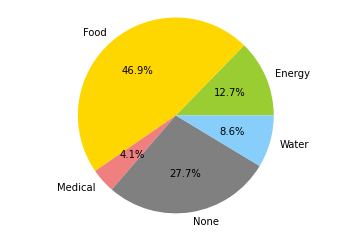

In [83]:
tweets, test_tweets = lib.read_data()
sandy_tweets = tweets+test_tweets
lib.class_pie_chart(sandy_tweets)

2.) Draw a bar chart for performance metrics: precision, recall, f1 of the Naive Bayes classifier with bigrams by running the cell below. 

Energy
Precision:  60.869565217391305
Recall:  70.0
F1:  65.11627906976743

Food
Precision:  84.39716312056737
Recall:  92.24806201550388
F1:  88.14814814814815

Medical
Precision:  75.0
Recall:  46.15384615384615
F1:  57.14285714285714

None
Precision:  83.78378378378379
Recall:  78.48101265822785
F1:  81.04575163398694

Water
Precision:  83.33333333333333
Recall:  50.0
F1:  62.5

Average F1:  70.79060719895193


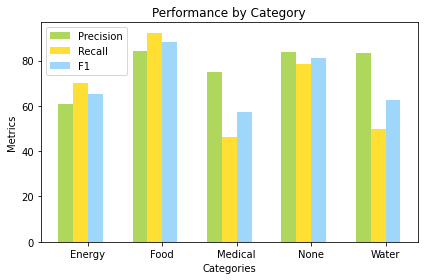

In [106]:
tweets, test_tweets = lib.read_data()
prior_probs, token_probs = lib.learn_nb(tweets)
predictions = [(tweet, lib.classify_nb(tweet, prior_probs, token_probs)) for tweet in test_tweets]
labels, precisions, recalls, f1s = lib.evaluate(predictions, has_return=True)
lib.metric_bar_chart(labels, precisions, recalls, f1s)

3.) Generate a bar chart using the results of your best MLP above and filling in the code below. What can you takeaway by comparing the bar charts. 

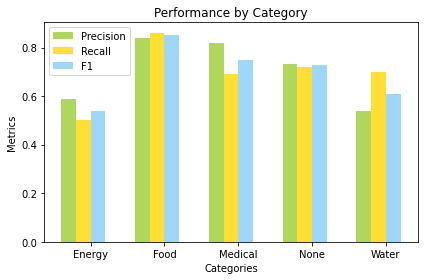

In [108]:
mlp_predicted_classes = clf.predict(test_tweets_vecs)
# use the same labels as the bar chart above for easier comparison
precisions, recalls, f1s, _ = precision_recall_fscore_support(test_classes, mlp_predicted_classes, labels=labels, average=None)
lib.metric_bar_chart(labels, precisions, recalls, f1s)

4.) Extension: take a look at the functions `class_pie_chart` and `metric_bar_chart` inn `lib.py` to see how you can use matplotlib to create similar plots. 